In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load, dump
from tqdm.auto import tqdm
from google.colab import drive
import os
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
def load_and_prepare_data(features_path, tracks_path, group_by = 0):
    """
    Load music features and track metadata; prep for decade classification
    """
    def read_features_file(file_path):
        df = pd.read_csv(file_path, header=[0, 1, 2], low_memory=False)

        df.columns = ['_'.join(str(col) for col in col_tuple if col).strip()
                      for col_tuple in df.columns.values]
        return df

    print("Loading features data...")
    features_df = read_features_file(features_path)

    features_df = features_df.reset_index()
    features_df.rename(columns={'index': 'track_id'}, inplace=True)
    # print(features_df.head())
    # print(features_df.columns)
    # features_df = features_df.drop('feature_statistics_number', axis=1)


    print("Loading tracks data...")
    tracks_df = pd.read_csv(tracks_path, low_memory=False)
    print(tracks_df.head())
    print(tracks_df.columns)



    # first save the first 100 tracks into a separate csv
    # tracks_df.head(100).to_csv('data/first_100_tracks.csv', index=False)

    # this is the code for setting genre_top
    if 'track.7' in tracks_df.columns:
        tracks_df['top_genre'] = tracks_df['track.7']

    #this is the code for setting list of genres
    if 'track.9' in tracks_df.columns:
        tracks_df['genres'] = tracks_df['track.9']

    #filter out tracks without year label
    if 'album.2' in tracks_df.columns:
        tracks_df['year'] = pd.to_datetime(tracks_df['album.2'], errors='coerce').dt.year
    else:
        date_cols = [col for col in tracks_df.columns if 'date_released' in str(col).lower()]
        if date_cols:
            tracks_df['year'] = pd.to_datetime(tracks_df[date_cols[0]], errors='coerce').dt.year
        else:
            tracks_df['year'] = pd.to_datetime(tracks_df['track.3'], errors='coerce').dt.year

    if 'track_id' not in tracks_df.columns:
        if 'Unnamed: 0' in tracks_df.columns:
            tracks_df = tracks_df[2:].copy()
            tracks_df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True)
            tracks_df['track_id'] = pd.to_numeric(tracks_df['track_id'], errors='coerce')


    print(f"tracks_df shape before dropna: {tracks_df.shape}")
    tracks_df = tracks_df.dropna(subset=['track_id'])
    print(f"tracks_df shape after dropna: {tracks_df.shape}")



    #focus range between 2009 and 2013 in order to isolate balanced and robust data set
    tracks_df = tracks_df[(tracks_df['year'] >= 2009) & (tracks_df['year'] <= 2013)]


    features_df['track_id'] = features_df['track_id'].astype(int)
    tracks_df['track_id'] = tracks_df['track_id'].astype(int)

    # tracks_df.head(100).to_csv('data/first_100_tracks_filtered.csv', index=False)

    # print("Merging datasets...")
    print(f"Features shape before merge: {features_df.shape}")
    print(f"Tracks shape before merge: {tracks_df.shape}")
    print(f"Feature columns: {features_df.columns[:5]}...")
    print(f"Tracks columns being used: track_id, decade")

    features_df['track_id'] = features_df['track_id'].astype(int)
    tracks_df['track_id'] = tracks_df['track_id'].astype(int)

    merged_df = pd.merge(features_df, tracks_df[['track_id', 'year']],
                         on='track_id', how='inner')

    print(f"Merged dataframe shape: {merged_df.shape}")

    # merged_df.head(1000).to_csv('data/first_1000_tracks_merged.csv', index=False)

    feature_cols = [col for col in merged_df.columns if col != 'track_id' and col != 'year']
    X = merged_df[feature_cols]
    y = merged_df['year']

    print(f"Total samples: {len(X)}")
    print(f"Number of features: {X.shape[1]}")

    print(f"Year distribution: {y.value_counts().sort_index()}")




    return X, y

In [3]:
# TODO for graders: Set this path string to match the directory at the root of this project.

drive.mount('/content/drive/', force_remount=False)
os.chdir('/content/drive/MyDrive/Colab Notebooks/CPSC381/Final Project')


Mounted at /content/drive/


In [4]:
tracks_path = 'fma_metadata/tracks.csv'
features_path = 'fma_metadata/features.csv'
X, y = load_and_prepare_data(features_path, tracks_path)


Loading features data...
Loading tracks data...
  Unnamed: 0     album              album.1              album.2   album.3  \
0        NaN  comments         date_created        date_released  engineer   
1   track_id       NaN                  NaN                  NaN       NaN   
2          2         0  2008-11-26 01:44:45  2009-01-05 00:00:00       NaN   
3          3         0  2008-11-26 01:44:45  2009-01-05 00:00:00       NaN   
4          5         0  2008-11-26 01:44:45  2009-01-05 00:00:00       NaN   

     album.4 album.5      album.6  album.7   album.8  ...     track.10  \
0  favorites      id  information  listens  producer  ...  information   
1        NaN     NaN          NaN      NaN       NaN  ...          NaN   
2          4       1      <p></p>     6073       NaN  ...          NaN   
3          4       1      <p></p>     6073       NaN  ...          NaN   
4          4       1      <p></p>     6073       NaN  ...          NaN   

   track.11       track.12            

/tmp/ipython-input-3311218289.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tracks_df['year'] = pd.to_datetime(tracks_df['album.2'], errors='coerce').dt.year


tracks_df shape before dropna: (106574, 56)
tracks_df shape after dropna: (106574, 56)
Features shape before merge: (106575, 520)
Tracks shape before merge: (35861, 56)
Feature columns: Index(['track_id', 'feature_statistics_number', 'chroma_cens_kurtosis_01',
       'chroma_cens_kurtosis_02', 'chroma_cens_kurtosis_03'],
      dtype='object')...
Tracks columns being used: track_id, decade
Merged dataframe shape: (32290, 521)
Total samples: 32290
Number of features: 519
Year distribution: year
2009.0    5864
2010.0    6275
2011.0    6607
2012.0    6798
2013.0    6746
Name: count, dtype: int64


In [5]:
def engineer_music_features(X):
        """Create additional music-specific features"""
        X_new = X.copy()

        chroma_features = [col for col in X.columns if 'chroma' in col.lower()]
        mfcc_features = [col for col in X.columns if 'mfcc' in col.lower()]
        spectral_features = [col for col in X.columns if 'spectral' in col.lower()]

        if len(chroma_features) > 0 and len(mfcc_features) > 0:
            for c_feat in chroma_features[:3]:
                for m_feat in mfcc_features[:3]:
                    X_new[f'ratio_{c_feat}_{m_feat}'] = X[c_feat] / (X[m_feat] + 1e-6)

        if len(mfcc_features) > 0:
            X_new['mfcc_mean'] = X[mfcc_features].mean(axis=1)
            X_new['mfcc_std'] = X[mfcc_features].std(axis=1)

        if len(spectral_features) > 0:
            X_new['spectral_mean'] = X[spectral_features].mean(axis=1)
            X_new['spectral_std'] = X[spectral_features].std(axis=1)

        return X_new



In [6]:
# preprocessing
# normalize feature values
X = engineer_music_features(pd.DataFrame(X))

scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )



# Convert year labels to integers in the range [0, num_classes - 1]
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# Use encoded labels for training
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# Use encoded labels for testing
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Splitting data into training and test sets...


In [9]:
experiment_number = 29
experimenter = "zev"
# Hyperparameters
input_dim = X.shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
# hidden_dim3 = 64
dropout_rate = 0.30
learning_rate = 0.01
num_epochs = 100
batch_size = train_loader.batch_size  # assumes DataLoader was set with batch_size
scheduler_step_size = 1
scheduler_gamma = 0.9
patience = 20

results_file = f"{experimenter}_data/nn_training_results_{experiment_number}.txt"
with open(results_file, "w") as f:
    f.write("Hyperparameters:\n")
    f.write(f"  Input dim        : {input_dim}\n")
    f.write(f"  Hidden layers    : {hidden_dim1}, {hidden_dim2}\n")
    f.write(f"  Dropout rate     : {dropout_rate}\n")
    f.write(f"  Learning rate    : {learning_rate}\n")
    f.write(f"  Epochs           : {num_epochs}\n")
    f.write(f"  Batch size       : {batch_size}\n")
    f.write(f"  Scheduler step   : {scheduler_step_size}\n")
    f.write(f"  Scheduler gamma  : {scheduler_gamma}\n\n")
    f.write("Epoch\tLoss\tTrain Acc\tVal Acc\n")


Training the model...
Epoch [1/100] | Loss: 1014.0223 | Train Acc: 0.4564 | Val Acc: 0.6493
Epoch [2/100] | Loss: 838.0939 | Train Acc: 0.5882 | Val Acc: 0.6900
Epoch [3/100] | Loss: 811.0704 | Train Acc: 0.6085 | Val Acc: 0.7200
Epoch [4/100] | Loss: 778.7968 | Train Acc: 0.6291 | Val Acc: 0.7307
Epoch [5/100] | Loss: 762.3172 | Train Acc: 0.6428 | Val Acc: 0.6898
Epoch [6/100] | Loss: 742.6376 | Train Acc: 0.6579 | Val Acc: 0.7101
Epoch [7/100] | Loss: 738.0976 | Train Acc: 0.6576 | Val Acc: 0.7145
Epoch [8/100] | Loss: 732.1358 | Train Acc: 0.6609 | Val Acc: 0.7307
Epoch [9/100] | Loss: 717.0708 | Train Acc: 0.6747 | Val Acc: 0.7405
Epoch [10/100] | Loss: 702.3586 | Train Acc: 0.6802 | Val Acc: 0.7406
Epoch [11/100] | Loss: 693.4622 | Train Acc: 0.6855 | Val Acc: 0.7295
Epoch [12/100] | Loss: 692.1148 | Train Acc: 0.6893 | Val Acc: 0.6629
Epoch [13/100] | Loss: 682.5761 | Train Acc: 0.6932 | Val Acc: 0.7535
Epoch [14/100] | Loss: 671.5546 | Train Acc: 0.6991 | Val Acc: 0.7490
Epoch 

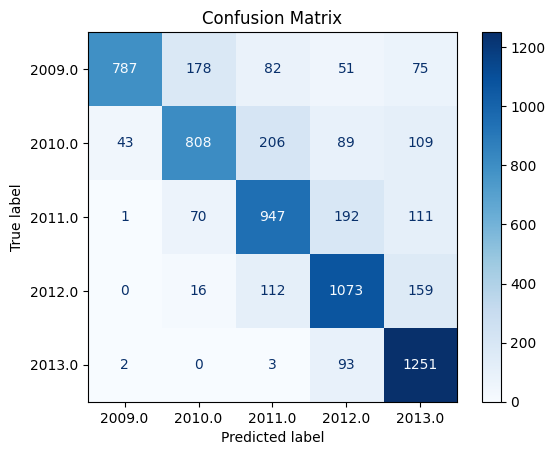

In [10]:
class SongClassifierADV(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),

            # nn.Linear(hidden2, hidden3),
            # nn.BatchNorm1d(hidden3),
            # nn.ReLU(),
            # nn.Dropout(dropout),

            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

num_classes = len(label_encoder.classes_)  # Add this line
model = SongClassifierADV(input_dim, hidden_dim1, hidden_dim2, dropout_rate, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

best_val_acc = 0.0
epochs_no_improve = 0

training_losses = []
training_accuracies = []
validation_accuracies = []
last_epoch = 0 # to track early stopping

print("Training the model...")
for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_loss = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(dim=1) == batch_y).sum().item()


    train_acc = train_correct / len(train_dataset)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_predicted = val_outputs.argmax(dim=1)
        val_correct = (val_predicted == y_test_tensor).sum().item()
        val_acc = val_correct / len(test_dataset)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}") # write this line to file with hyperparams
    with open(results_file, "a") as f:
      f.write(f"{epoch+1}\t{train_loss:.4f}\t{train_acc:.4f}\t{val_acc:.4f}\n")


    # save for plots
    training_losses.append(train_loss)
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)


    # Optional: Early stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            last_epoch = epoch + 1
            break

# Load best model if early stopping is used
model.load_state_dict(torch.load('best_model.pt'))
if last_epoch == 0:
    last_epoch = num_epochs


model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = outputs.argmax(dim=1)
    accuracy = (predicted == y_test_tensor).float().mean()
    print(f"Final Test Accuracy: {accuracy:.4f}")

with open(results_file, "a") as f:
    if epochs_no_improve >= patience:
        f.write(f"\nEarly stopping triggered at epoch {last_epoch}.\n")
    f.write(f"Final Test Accuracy: {accuracy:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test_encoded, predicted.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig(f"{experimenter}_data/nn_confusion_matrix_{experiment_number}.png")  # Saves instead of just showing
plt.show()




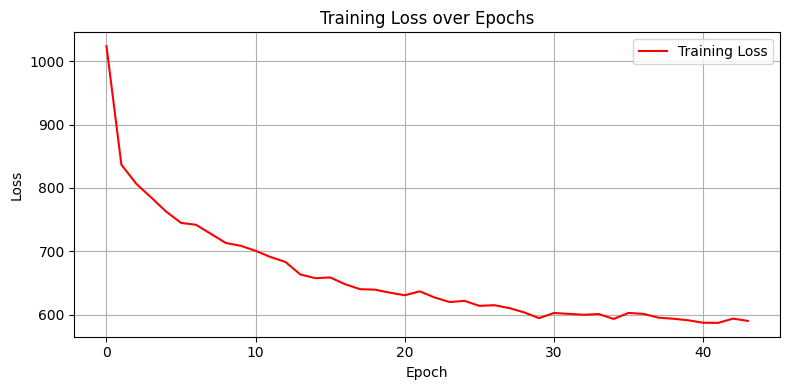

In [ ]:
# plots

plt.figure(figsize=(8, 4))
plt.plot(range(last_epoch), training_losses, label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{experimenter}_data/nn_loss{experiment_number}.png")  # Saves instead of just showing
plt.show()


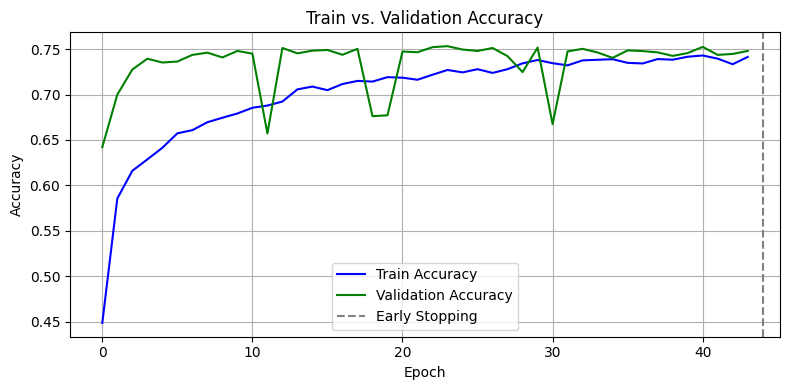

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(last_epoch), training_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(last_epoch), validation_accuracies, label='Validation Accuracy', color='green')
plt.axvline(x=last_epoch, color='gray', linestyle='--', label='Early Stopping')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{experimenter}_data/nn_train_and_accuracy{experiment_number}.png")  # Saves instead of just showing
plt.show()


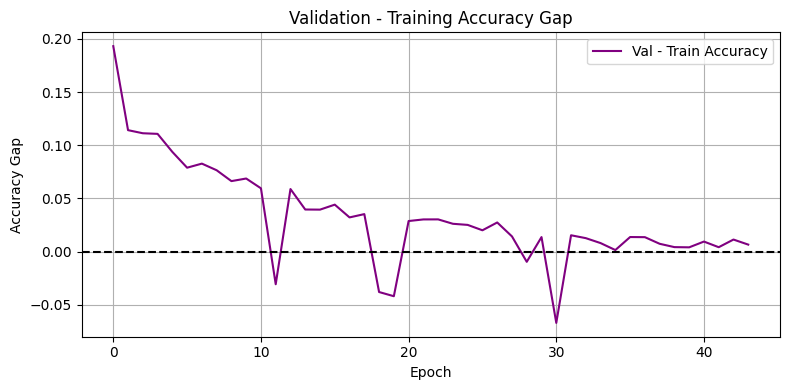

In [ ]:
gap = np.array(validation_accuracies) - np.array(training_accuracies)

plt.figure(figsize=(8, 4))
plt.plot(range(last_epoch), gap, label='Val - Train Accuracy', color='purple')
plt.axhline(y=0, linestyle='--', color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap')
plt.title('Validation - Training Accuracy Gap')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{experimenter}_data/nn_val_train_gap{experiment_number}.png")  # Saves instead of just showing
plt.show()
